In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../Lab1/data/Housing.csv')
print(df.head())
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())

# Custom missing value handling functions
def fill_missing_with_zero(data):
    return data.fillna(0)

def fill_missing_with_mean(data):
    df_copy = data.copy()
    for col in df_copy.columns:
        if df_copy[col].dtype in [np.float64, np.int64]:
            mean_val = df_copy[col].mean()
            df_copy[col] = df_copy[col].fillna(mean_val)
    return df_copy

def fill_missing_with_median(data):
    df_copy = data.copy()
    for col in df_copy.columns:
        if df_copy[col].dtype in [np.float64, np.int64]:
            median_val = df_copy[col].median()
            df_copy[col] = df_copy[col].fillna(median_val)
    return df_copy

df_zero = fill_missing_with_zero(df)
df_mean = fill_missing_with_mean(df)
df_median = fill_missing_with_median(df)
print('\nMissing values after filling with zero:')
print(df_zero.isnull().sum())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 colu

Custom Normalization

In [2]:
def min_max_scaling(data):
    df_scaled = data.copy()
    for col in df_scaled.columns:
        if df_scaled[col].dtype in [np.float64, np.int64]:
            min_val = df_scaled[col].min()
            max_val = df_scaled[col].max()
            if max_val - min_val != 0:
                df_scaled[col] = (df_scaled[col] - min_val) / (max_val - min_val)
            else:
                df_scaled[col] = 0
    return df_scaled

def standard_scaling(data):
    df_scaled = data.copy()
    for col in df_scaled.columns:
        if df_scaled[col].dtype in [np.float64, np.int64]:
            mean_val = df_scaled[col].mean()
            std_val = df_scaled[col].std()
            if std_val != 0:
                df_scaled[col] = (df_scaled[col] - mean_val) / std_val
            else:
                df_scaled[col] = 0
    return df_scaled

df_zero_minmax = min_max_scaling(df_zero)
df_zero_std = standard_scaling(df_zero)
df_mean_minmax = min_max_scaling(df_mean)
df_mean_std = standard_scaling(df_mean)
df_median_minmax = min_max_scaling(df_median)
df_median_std = standard_scaling(df_median)

print('First 5 rows after Min-Max scaling (zero fill):')
print(df_zero_minmax.head())

First 5 rows after Min-Max scaling (zero fill):
      price      area  bedrooms  bathrooms   stories mainroad guestroom  \
0  1.000000  0.396564       0.6   0.333333  0.666667      yes        no   
1  0.909091  0.502405       0.6   1.000000  1.000000      yes        no   
2  0.909091  0.571134       0.4   0.333333  0.333333      yes        no   
3  0.906061  0.402062       0.6   0.333333  0.333333      yes        no   
4  0.836364  0.396564       0.6   0.000000  0.333333      yes       yes   

  basement hotwaterheating airconditioning   parking prefarea furnishingstatus  
0       no              no             yes  0.666667      yes        furnished  
1       no              no             yes  1.000000       no        furnished  
2      yes              no              no  0.666667      yes   semi-furnished  
3      yes              no             yes  1.000000      yes        furnished  
4      yes              no             yes  0.666667       no        furnished  


Outlier Detection and Removal (Z-score and IQR methods)

In [3]:
def detect_outliers_zscore(data, threshold=3):
    outlier_indices = set()
    for col in data.columns:
        if data[col].dtype in [np.float64, np.int64]:
            mean = data[col].mean()
            std = data[col].std()
            if std == 0: continue
            z_scores = (data[col] - mean) / std
            outliers = data.index[abs(z_scores) > threshold]
            outlier_indices.update(outliers)
    return list(outlier_indices)

def detect_outliers_iqr(data, factor=1.5):
    outlier_indices = set()
    for col in data.columns:
        if data[col].dtype in [np.float64, np.int64]:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - factor * IQR
            upper = Q3 + factor * IQR
            outliers = data.index[(data[col] < lower) | (data[col] > upper)]
            outlier_indices.update(outliers)
    return list(outlier_indices)

def remove_outliers(data, outlier_indices):
    return data.drop(index=outlier_indices)

# Detect and remove outliers from df_mean_minmax using Z-score
z_outliers = detect_outliers_zscore(df_mean_minmax)
print(f'Number of outliers detected by Z-score: {len(z_outliers)}')
df_mean_minmax_no_outliers = remove_outliers(df_mean_minmax, z_outliers)

# Detect and remove outliers from df_mean_minmax using IQR
iqr_outliers = detect_outliers_iqr(df_mean_minmax)
print(f'Number of outliers detected by IQR: {len(iqr_outliers)}')
df_mean_minmax_no_outliers_iqr = remove_outliers(df_mean_minmax, iqr_outliers)

Number of outliers detected by Z-score: 23
Number of outliers detected by IQR: 82


In [ ]:
# Visualize outlier points for two selected numeric columns
def plot_outliers(data, outlier_indices, col_x, col_y, title):
    plt.figure(figsize=(8,6))
    plt.scatter(data[col_x], data[col_y], label='Normal', alpha=0.6)
    if outlier_indices:
        plt.scatter(data.loc[outlier_indices, col_x], data.loc[outlier_indices, col_y], color='red', label='Outliers', marker='x')
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(title)
    plt.legend()
    plt.show()

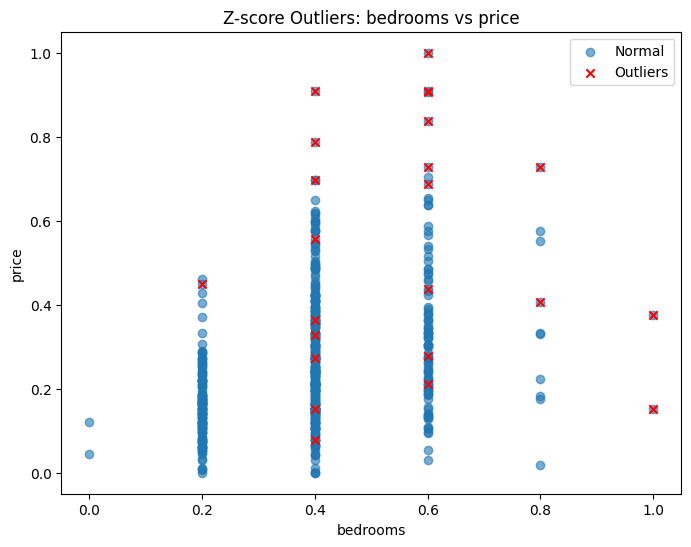

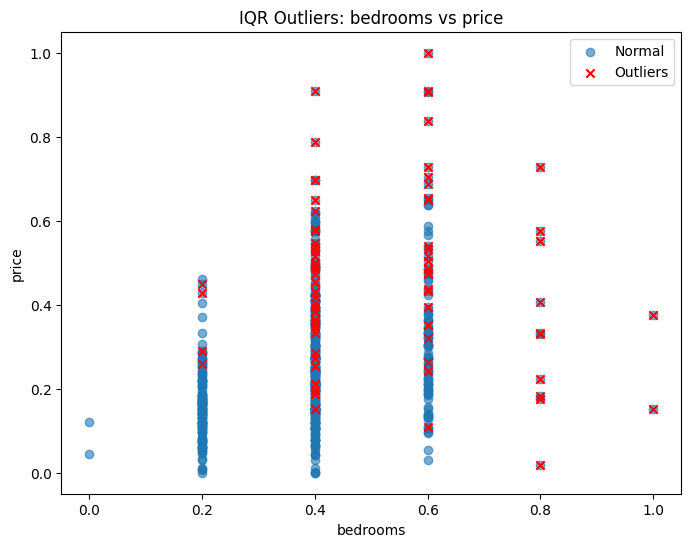

In [7]:
# Visualize outliers for 'bedrooms' vs 'price' (if columns exist)
if 'price' in df_mean_minmax.columns and 'bedrooms' in df_mean_minmax.columns:
    plot_outliers(df_mean_minmax, z_outliers, 'bedrooms', 'price', 'Z-score Outliers: bedrooms vs price')
    plot_outliers(df_mean_minmax, iqr_outliers, 'bedrooms', 'price', 'IQR Outliers: bedrooms vs price')

# Visualize outliers for 'bathrms' vs 'lotsize' (if columns exist)
if 'lotsize' in df_mean_minmax.columns and 'bathrms' in df_mean_minmax.columns:
    plot_outliers(df_mean_minmax, z_outliers, 'bathrms', 'lotsize', 'Z-score Outliers: bathrms vs lotsize')
    plot_outliers(df_mean_minmax, iqr_outliers, 'bathrms', 'lotsize', 'IQR Outliers: bathrms vs lotsize')